In [1]:
import os, subprocess, re
import MDAnalysis as mda
from MDAnalysis.analysis import align
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem

from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem
from rdkit import Chem, DataStructs

In [2]:
PATH = "test_analysis/combined_1EEI/"
pdb_1EE1_dir = os.listdir(PATH)

In [3]:
LIGAND_RES_THRESH = 10 # 10 angstroms from any ligand atom to nearby residue

In [5]:
def get_pocket_residues(ligand_atoms, ligand_atom_positions, protein_residues, protein_residue_coms):
    pocket_residues = set()

    for i in range(len(ligand_atoms)):
        atom = ligand_atoms[i]
        atom_xyz = ligand_atom_positions[i]

        for j, res in enumerate(protein_residues):
            if np.linalg.norm(atom_xyz - protein_residue_coms[j]) <= LIGAND_RES_THRESH:
                pocket_residues.add(res)

    pocket_residues = list(pocket_residues)
    return pocket_residues

In [6]:
frame_pocket_sets = {}
frame_universes = {}

for fp in pdb_1EE1_dir:
    if "_bonds" in fp: # only look at files with CONECT bond information inside
        frame_idx = re.findall(r"\d+", fp)[1]
        pdb_fp = PATH + fp
        frame_uni = mda.Universe(pdb_fp, format="PDB")
        ligand_atoms = frame_uni.select_atoms("resname MOL")
        protein_atoms = frame_uni.select_atoms("protein")

        ligand_positions = ligand_atoms.positions

        protein_residues = protein_atoms.residues
        protein_residue_coms = [res.atoms.center_of_mass() for res in protein_atoms.residues]

        pocket_residues = get_pocket_residues(ligand_atoms, ligand_positions, protein_residues, protein_residue_coms)

        frame_pocket_sets[frame_idx] = pocket_residues
        frame_universes[frame_idx] = frame_uni

/opt/anaconda3/envs/pyg3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


In [7]:
from pprint import pprint

pocket_sizes = []
for key, val in frame_pocket_sets.items():
    pocket_sizes.append([len(val), key])
    
max_pocket_info = max(pocket_sizes, key=lambda x : x[0])
print (max_pocket_info)

[42, '7']


Get the largest set of residues as the ground truth pocket set

In [8]:
FINAL_1EEI_POCKET_RESIDUES = frame_pocket_sets[max_pocket_info[1]]
print (FINAL_1EEI_POCKET_RESIDUES)

[<Residue SER, 133>, <Residue LEU, 134>, <Residue ALA, 135>, <Residue GLY, 136>, <Residue LYS, 137>, <Residue ARG, 138>, <Residue GLU, 11>, <Residue TYR, 12>, <Residue HIE, 13>, <Residue ASN, 14>, <Residue THR, 15>, <Residue CYX, 9>, <Residue LEU, 8>, <Residue ALA, 10>, <Residue GLU, 139>, <Residue GLN, 49>, <Residue VAL, 50>, <Residue GLU, 51>, <Residue VAL, 52>, <Residue PRO, 53>, <Residue GLY, 54>, <Residue GLN, 56>, <Residue HIE, 57>, <Residue ILE, 58>, <Residue SER, 60>, <Residue GLN, 61>, <Residue LYS, 62>, <Residue ALA, 64>, <Residue ILE, 65>, <Residue MET, 68>, <Residue CYX, 86>, <Residue VAL, 87>, <Residue TRP, 88>, <Residue ASN, 89>, <Residue ASN, 90>, <Residue LYS, 91>, <Residue THR, 92>, <Residue PRO, 93>, <Residue HIE, 94>, <Residue ALA, 95>, <Residue ILE, 96>, <Residue ALA, 97>]


In [ ]:
og_cry_uni = mda.Universe("og_crystal_structs/1eei_og_crystal.pdb", format="PDB")

In [116]:
from MDAnalysis.analysis import rms

def get_pocket_residues_rmsd(pocket_resnames, all_frame_universes_dict, resolution="all_atom"):
    mda_query = ""
    for res in pocket_resnames[:-1]:
        if resolution == "all_atom":
            mda_query += f"(resid {res.resindex}) or "
        elif resolution == "ca":
            mda_query += f"(resid {res.resindex} and name CA) or "
    mda_query += f"(resid {pocket_resnames[-1].resindex})"
    
    print (mda_query)
        
    reference_uni = all_frame_universes_dict['0'] # pick first frame
    
    for i in range(len(all_frame_universes_dict)):
        if i != 0:
            uni_to_align = all_frame_universes_dict[str(i)]
            align.alignto(uni_to_align, reference_uni)
        
    framewise_pocket_rmsd = [(0,0) for _ in range(len(all_frame_universes_dict))]
    ref_pocket = reference_uni.select_atoms(mda_query)
    for i in range(len(all_frame_universes_dict)):
        if i != 0:
            frame_uni = all_frame_universes_dict[str(i)]
            pocket_j = frame_uni.select_atoms(mda_query)
            r = rms.rmsd(ref_pocket.positions, pocket_j.positions, superposition=True, center=True)
            framewise_pocket_rmsd[i] = (r, i)
            
    sorted_framewise_pocket_rmsd = sorted(framewise_pocket_rmsd, key=lambda x : x[0])
                
    return sorted_framewise_pocket_rmsd, framewise_pocket_rmsd

In [118]:
sorted_framewise_pocket_rmsd_details, unsorted_framewise_pocket_rmsd_details = get_pocket_residues_rmsd(FINAL_1EEI_POCKET_RESIDUES, frame_universes, resolution="ca")
sorted_framewise_pocket_rmsd_labels = [rec[1] for rec in sorted_framewise_pocket_rmsd_details]
sorted_framewise_pocket_rmsd = [rec[0] for rec in sorted_framewise_pocket_rmsd_details]

(resid 132 and name CA) or (resid 133 and name CA) or (resid 134 and name CA) or (resid 135 and name CA) or (resid 136 and name CA) or (resid 137 and name CA) or (resid 10 and name CA) or (resid 11 and name CA) or (resid 12 and name CA) or (resid 13 and name CA) or (resid 14 and name CA) or (resid 8 and name CA) or (resid 7 and name CA) or (resid 9 and name CA) or (resid 138 and name CA) or (resid 48 and name CA) or (resid 49 and name CA) or (resid 50 and name CA) or (resid 51 and name CA) or (resid 52 and name CA) or (resid 53 and name CA) or (resid 55 and name CA) or (resid 56 and name CA) or (resid 57 and name CA) or (resid 59 and name CA) or (resid 60 and name CA) or (resid 61 and name CA) or (resid 63 and name CA) or (resid 64 and name CA) or (resid 67 and name CA) or (resid 85 and name CA) or (resid 86 and name CA) or (resid 87 and name CA) or (resid 88 and name CA) or (resid 89 and name CA) or (resid 90 and name CA) or (resid 91 and name CA) or (resid 92 and name CA) or (resid 9

[0, 5, 1, 37, 25, 2, 4, 3, 28, 38, 26, 36, 7, 39, 13, 42, 8, 32, 34, 35, 27, 31, 6, 30, 33, 40, 11, 29, 23, 17, 12, 14, 45, 41, 15, 10, 21, 44, 16, 69, 24, 52, 47, 64, 54, 53, 43, 56, 60, 9, 46, 57, 19, 50, 48, 62, 20, 79, 49, 51, 78, 77, 80, 22, 58, 18, 98, 55, 65, 67, 71, 74, 59, 68, 61, 90, 63, 70, 66, 81, 89, 75, 94, 88, 82, 72, 76, 73, 91, 99, 84, 83, 87, 95, 93, 96, 97, 85, 92, 86]


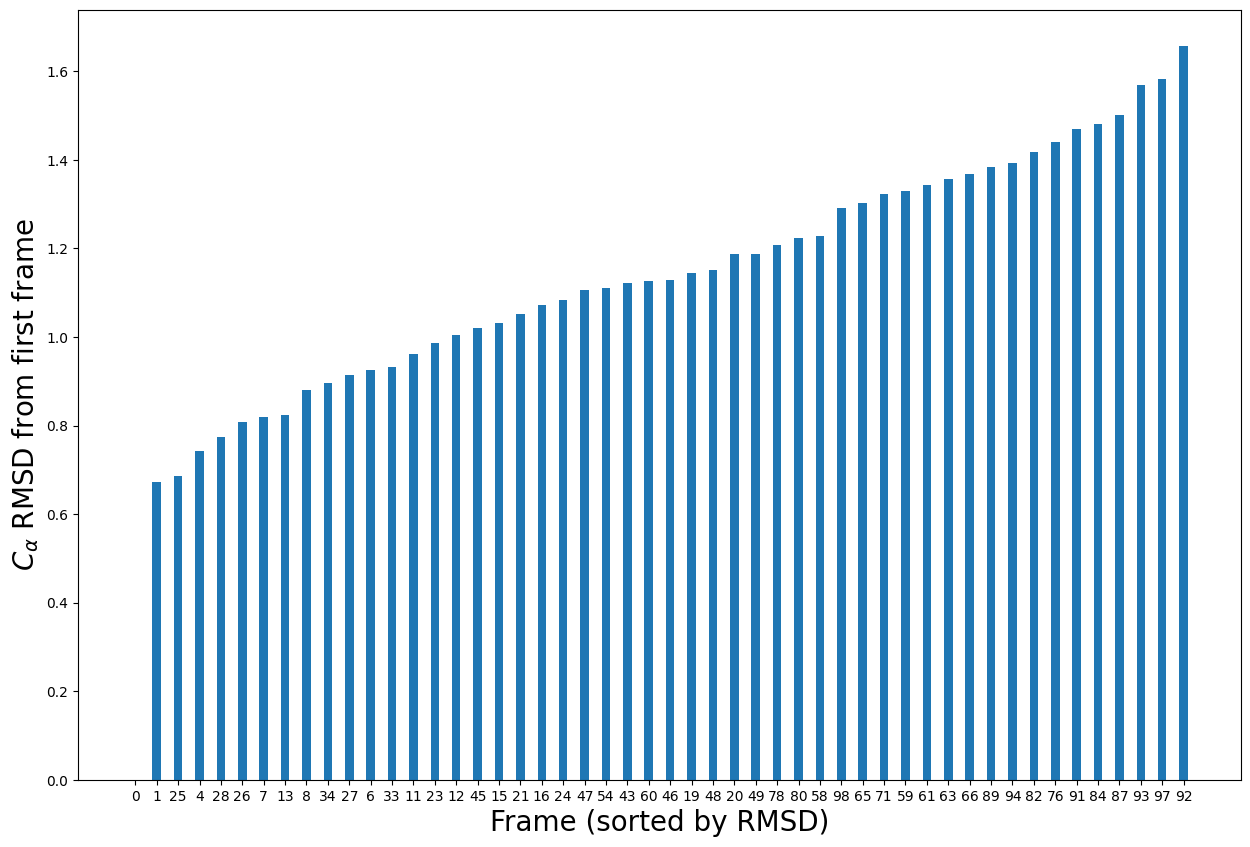

In [121]:
print (sorted_framewise_pocket_rmsd_labels)

fig = plt.figure(figsize=(15, 10))
plt.bar(height=sorted_framewise_pocket_rmsd[::2], x=range(len(sorted_framewise_pocket_rmsd_labels))[::2])
plt.xlabel("Frame (sorted by RMSD)", fontsize=20)
plt.ylabel("$C_\\alpha$ RMSD from first frame", fontsize=20)
plt.xticks(range(len(sorted_framewise_pocket_rmsd_labels))[::2], sorted_framewise_pocket_rmsd_labels[::2], size=10)
plt.show()

[0, 5, 1, 37, 25, 2, 4, 3, 28, 38, 26, 36, 7, 39, 13, 42, 8, 32, 34, 35, 27, 31, 6, 30, 33, 40, 11, 29, 23, 17, 12, 14, 45, 41, 15, 10, 21, 44, 16, 69, 24, 52, 47, 64, 54, 53, 43, 56, 60, 9, 46, 57, 19, 50, 48, 62, 20, 79, 49, 51, 78, 77, 80, 22, 58, 18, 98, 55, 65, 67, 71, 74, 59, 68, 61, 90, 63, 70, 66, 81, 89, 75, 94, 88, 82, 72, 76, 73, 91, 99, 84, 83, 87, 95, 93, 96, 97, 85, 92, 86]


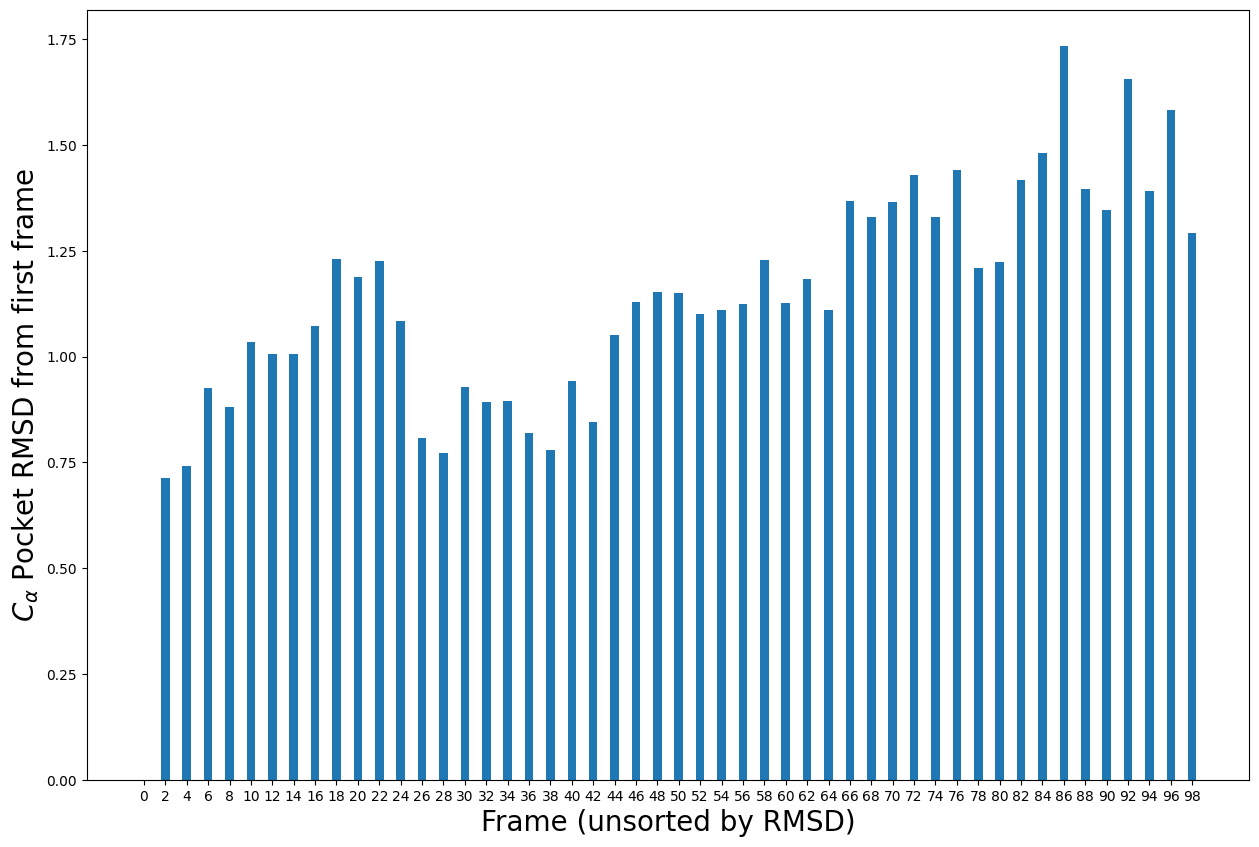

In [120]:
unsorted_framewise_pocket_rmsd_labels = [rec[1] for rec in unsorted_framewise_pocket_rmsd_details]
unsorted_framewise_pocket_rmsd = [rec[0] for rec in unsorted_framewise_pocket_rmsd_details]

print (sorted_framewise_pocket_rmsd_labels)

fig = plt.figure(figsize=(15, 10))
plt.bar(height=unsorted_framewise_pocket_rmsd[::2], x=range(len(unsorted_framewise_pocket_rmsd_labels))[::2])
plt.xlabel("Frame (unsorted by RMSD)", fontsize=20)
plt.ylabel("$C_\\alpha$ Pocket RMSD from first frame", fontsize=20)
plt.xticks(range(len(unsorted_framewise_pocket_rmsd_labels))[::2], unsorted_framewise_pocket_rmsd_labels[::2], size=10, )
plt.show()

In [105]:
# each folder corresponds to the ~20 ligands generated for ONE frame

generated_ligand_path_1EEI_f41 = "analysis_results/results_1EEI/frame_41_1EEI/1EEI_MD_frame41_bonds_mol.sdf"
# generated_ligand_framewise_dir_1EEI = os.listdir(generated_ligand_path_1EEI)

In [106]:
all_mols = []
supplier = Chem.SDMolSupplier(generated_ligand_path_1EEI_f41)
for mol in supplier:
    all_mols.append(mol)
    
pprint (all_mols)
print (len(all_mols))

20


In [107]:
table = [[0 for _ in range(len(all_mols))] for _ in range(len(all_mols))]

for i, mi in enumerate(all_mols):
    fpi = FingerprintMols.FingerprintMol(mi)
    for j, mj in enumerate(all_mols):
        if i != j:
            fpj = FingerprintMols.FingerprintMol(mj)
            tan = DataStructs.TanimotoSimilarity(fpi, fpj)
            table[i][j] = tan

table = np.array(table)            
print (table.shape)

(20, 20)


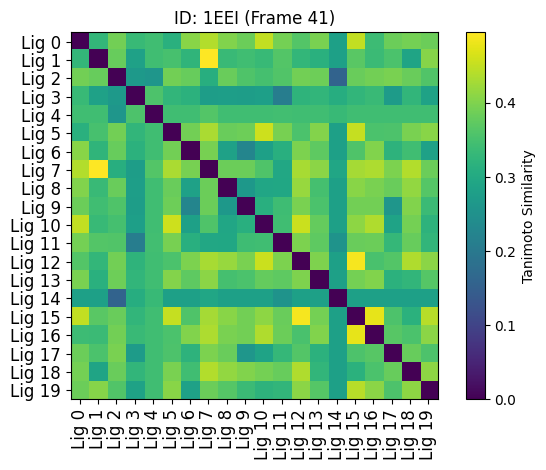

In [109]:
plt.imshow(table, cmap='viridis')
# plt.grid(True)
plt.colorbar(label=r'Tanimoto Similarity')
plt.title("ID: 1EEI (Frame 41)")
plt.xticks(ticks=range(len(all_mols)), labels=[f'Lig {i}' for i in range(len(all_mols))], rotation=90, fontsize=12)
plt.yticks(ticks=range(len(all_mols)), labels=[f'Lig {i}' for i in range(len(all_mols))], rotation=0, fontsize=12)
# plt.xlabel('Ligand', fontdict={'size': 17})
# plt.ylabel('Ligand', fontdict={'size': 17})
plt.tight_layout()
plt.show()

# Analysing Generated Ligands for `1EEI`

In [15]:
ligand_1EEI_path = "analysis_results/results_1EEI/"
ligand_1EEI_framewise_dir = os.listdir(ligand_1EEI_path)

In [16]:
ligand_store = {}

In [17]:
import re

for frame_dir in ligand_1EEI_framewise_dir:
    frame_idx = re.findall(r"\d+", frame_dir)[0]
    ligand_sdf_file_name = os.listdir(ligand_1EEI_path + "/" + frame_dir)[0]
    ligand_sdf_fp = ligand_1EEI_path + "/" + frame_dir + "/" + ligand_sdf_file_name
    all_mols = []

    supplier = Chem.SDMolSupplier(ligand_sdf_fp)
    for mol in supplier:
        all_mols.append(mol)

    ligand_store[frame_idx] = all_mols

[16:35:18] Explicit valence for atom # 28 N, 4, is greater than permitted
[16:35:18] ERROR: Could not sanitize molecule ending on line 720
[16:35:18] ERROR: Explicit valence for atom # 28 N, 4, is greater than permitted
[16:35:18] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:35:18] ERROR: Could not sanitize molecule ending on line 212
[16:35:18] ERROR: Explicit valence for atom # 10 N, 4, is greater than permitted
[16:35:18] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:35:18] ERROR: Could not sanitize molecule ending on line 503
[16:35:18] ERROR: Explicit valence for atom # 20 N, 4, is greater than permitted
[16:35:18] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:35:18] ERROR: Could not sanitize molecule ending on line 844
[16:35:18] ERROR: Explicit valence for atom # 13 N, 4, is greater than permitted
[16:35:18] Explicit valence for atom # 20 C, 5, is greater than permitted
[16:35:18] ERROR: Could not sanitize molecule 

In [21]:
import ligand_testbench as ltb

In [93]:
avg_qeds = {}
avg_tanimoto = {}

from rdkit.Chem.QED import qed

def compute_qed(mols):
    qeds = []
    for mol in mols:
        if mol:
            q = qed(mol)
            qeds.append(q)
    return qeds

def compute_tanimoto(all_mols):
    table = [[0 for _ in range(len(all_mols))] for _ in range(len(all_mols))]

    for i, mi in enumerate(all_mols):
        if mi:
            fpi = FingerprintMols.FingerprintMol(mi)
            for j, mj in enumerate(all_mols):
                if i != j and mi and mj:
                    try:
                        fpj = FingerprintMols.FingerprintMol(mj)
                        tan = DataStructs.TanimotoSimilarity(fpi, fpj)
                        table[i][j] = tan
                    except:
                        table[i][j] = 0

    table = np.array(table)            
    return table

for frame_id, molecules in ligand_store.items():
    frame_qeds = compute_qed(molecules)
    avg_frame_qed = np.array(frame_qeds).mean()
    std_frame_qed = np.array(frame_qeds).std()

    avg_qeds[frame_id] = [avg_frame_qed, std_frame_qed]
    
for frame_id, molecules in ligand_store.items():
    frame_tani = compute_tanimoto(molecules)
    avg_frame_tani = np.array(frame_tani).mean()
    std_frame_tani = np.array(frame_tani).std()

    avg_tanimoto[frame_id] = [avg_frame_tani, std_frame_tani]

# Pocket RMSD vs Avg Tanimoto

98 98 98


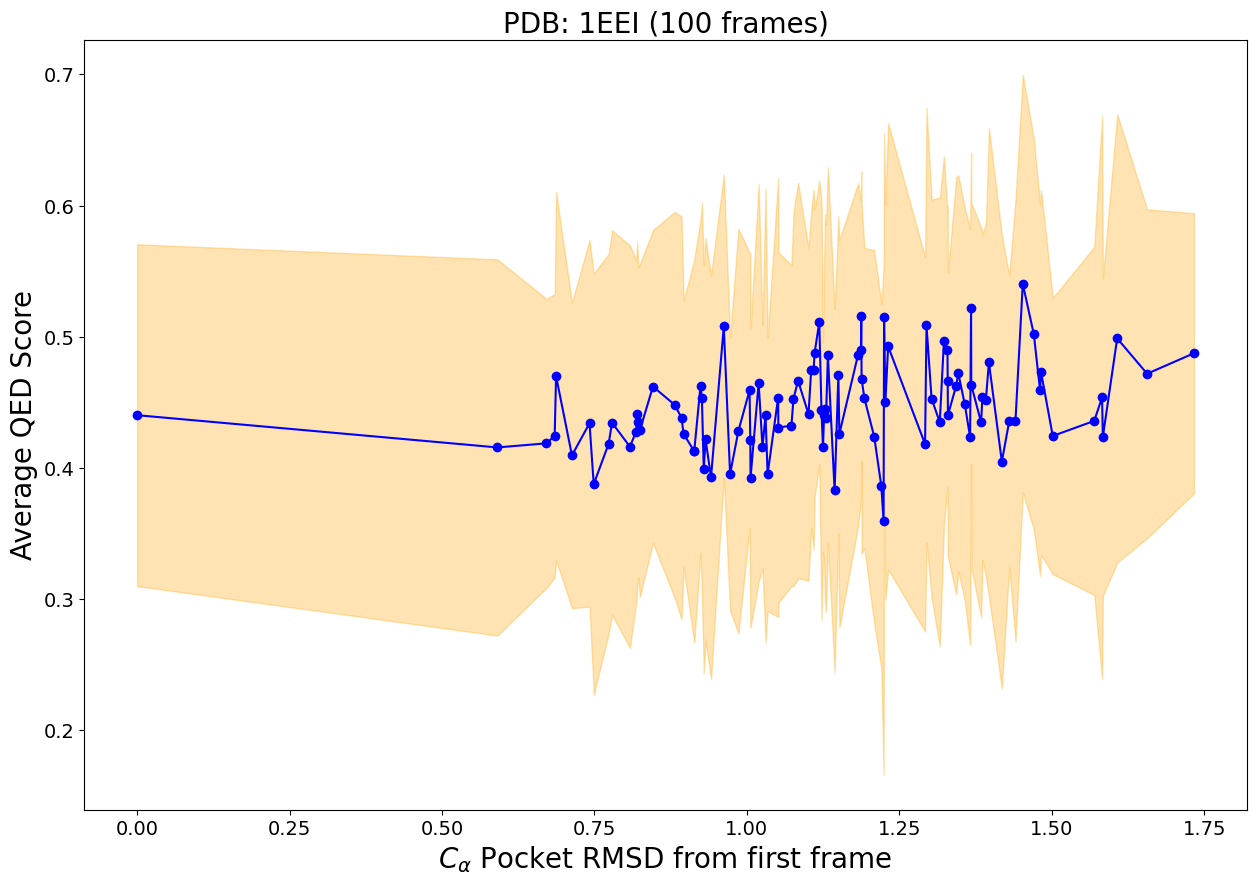

In [105]:
frame_id_keys = list(avg_qeds.keys())

final_qed_data = []
for frame_id, score in avg_qeds.items():
    frame_rmsd = unsorted_framewise_pocket_rmsd_details[int(frame_id)]
    final_qed_data.append([int(frame_id), frame_rmsd, score[0], score[1]])
    
sorted_qed_final_data = sorted(final_qed_data, key=lambda x : x[1]) # sort by RMSD
sorted_rmsds = [rec[1][0] for rec in sorted_qed_final_data]
sorted_avg_scores = [rec[2] for rec in sorted_qed_final_data]
sorted_std_scores = [rec[3] for rec in sorted_qed_final_data]
print (len(sorted_qed_final_data), len(sorted_rmsds), len(sorted_avg_scores))

itvl = 1
fig = plt.figure(figsize=(15, 10))
plt.plot(sorted_rmsds[::itvl], sorted_avg_scores[::itvl], marker="o", color="blue") # plot rmsd vs qed score
plt.fill_between(
    sorted_rmsds[::itvl], 
    np.array(sorted_avg_scores[::itvl]) + np.array(sorted_std_scores[::itvl]), 
    np.array(sorted_avg_scores[::itvl]) - np.array(sorted_std_scores[::itvl]),
    color="orange",
    alpha=0.3
)
plt.xlabel("$C_\\alpha$ Pocket RMSD from first frame", fontsize=20)
plt.ylabel("Average QED Score", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("PDB: 1EEI (100 frames)", fontsize=20)
plt.show()

# Pocket RMSD vs Avg Tanimoto

98 98 98


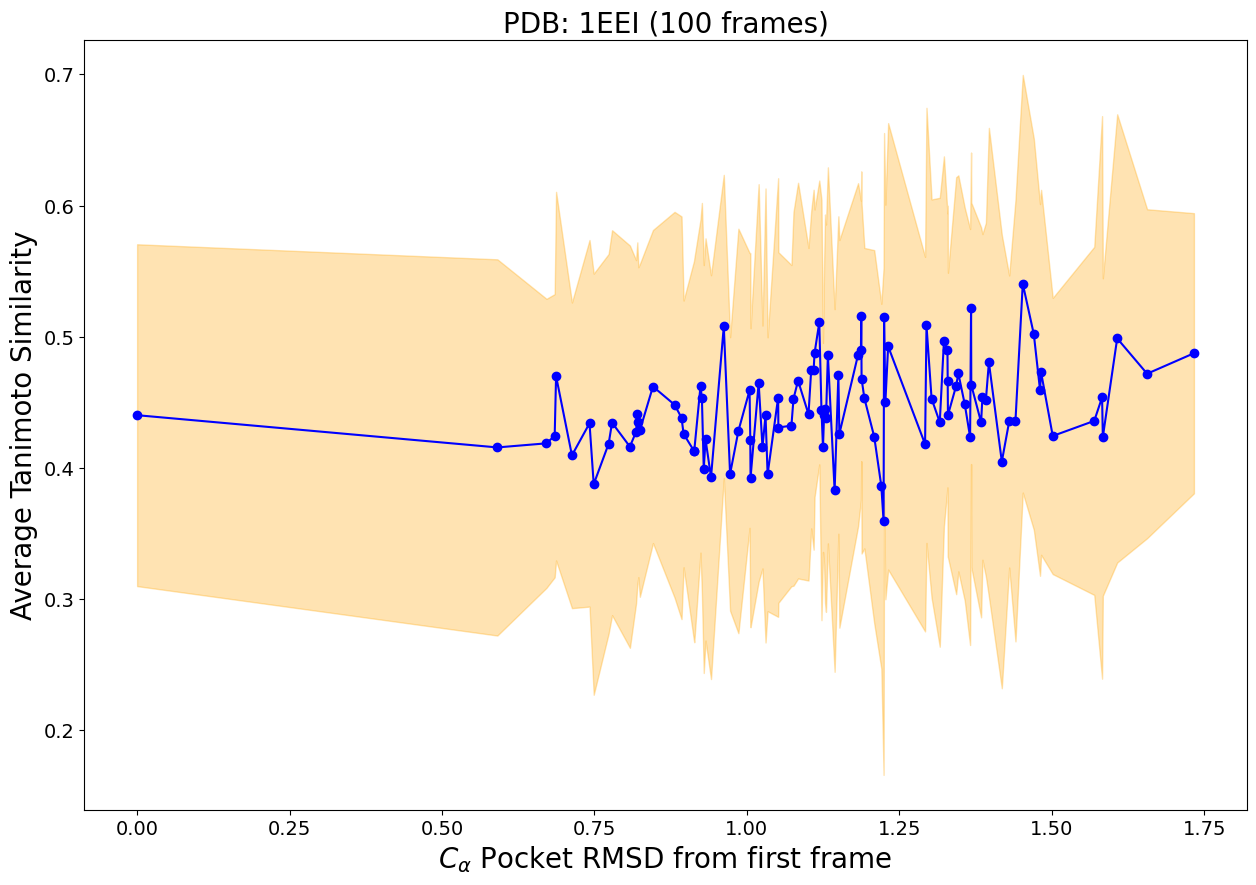

In [140]:
frame_id_keys = list(avg_qeds.keys())

final_tani_data = []
for frame_id, tani in avg_qeds.items():
    frame_rmsd = unsorted_framewise_pocket_rmsd_details[int(frame_id)]
    final_tani_data.append([int(frame_id), frame_rmsd, tani[0], tani[1]])
    
sorted_tani_final_data = sorted(final_tani_data, key=lambda x : x[1]) # sort by RMSD
sorted_rmsds = [rec[1][0] for rec in sorted_tani_final_data]
sorted_avg_tanis = [rec[2] for rec in sorted_tani_final_data]
sorted_std_tanis = [rec[3] for rec in sorted_tani_final_data]
print (len(sorted_tani_final_data), len(sorted_rmsds), len(sorted_avg_tanis))

itvl = 1
fig = plt.figure(figsize=(15, 10))
plt.plot(sorted_rmsds[::itvl], sorted_avg_tanis[::itvl], marker="o", color="blue") # plot rmsd vs tanimoto similarity
plt.fill_between(
    sorted_rmsds[::itvl], 
    np.array(sorted_avg_tanis[::itvl]) + np.array(sorted_std_tanis[::itvl]), 
    np.array(sorted_avg_tanis[::itvl]) - np.array(sorted_std_tanis[::itvl]),
    color="orange",
    alpha=0.3
)
plt.xlabel("$C_\\alpha$ Pocket RMSD from first frame", fontsize=20)
plt.ylabel("Average Tanimoto Similarity", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("PDB: 1EEI (100 frames)", fontsize=20)
plt.show()

# Pocket RMSD vs Number of Steric Clashes

In [130]:
def count_clashes(prot: Chem.Mol, lig: Chem.Mol, tolerance: float = 0.5):
    """
    Counts the number of clashes between atoms in a protein and a ligand.

    Args:
        prot: RDKit Mol object representing the protein.
        lig: RDKit Mol object representing the ligand.
        tolerance: Distance tolerance for clash detection (default: 0.5).

    Returns:
        clashes: Number of clashes between the protein and the ligand.
    """
    clashes = 0

    try:
        # Get the positions of atoms in the protein and ligand
        prot_pos = prot.GetConformer().GetPositions()
        lig_pos = lig.GetConformer().GetPositions()

        pt = Chem.GetPeriodicTable()

        # Get the number of atoms in the protein and ligand
        num_prot_atoms = prot.GetNumAtoms()
        num_lig_atoms = lig.GetNumAtoms()

        # Calculate the Euclidean distances between all atom pairs in the protein and ligand
        dists = np.linalg.norm(
            prot_pos[:, np.newaxis, :] - lig_pos[np.newaxis, :, :], axis=-1
        )

        # Iterate over the ligand atoms
        for i in range(num_lig_atoms):
            lig_vdw = pt.GetRvdw(lig.GetAtomWithIdx(i).GetAtomicNum())

            # Iterate over the protein atoms
            for j in range(num_prot_atoms):
                prot_vdw = pt.GetRvdw(prot.GetAtomWithIdx(j).GetAtomicNum())

                # Check for clash by comparing the distances with tolerance
                if dists[j, i] + tolerance < lig_vdw + prot_vdw:
                    clashes += 1

    except AttributeError:
        raise ValueError(
            "Invalid input molecules. Please provide valid RDKit Mol objects."
        )

    return clashes


#### Helper functions
def count_clashes_list(
    prot,
    ligs,
    target=None,
    tolerance=0.5,
):
    """
    Counts the number of clashes between atoms in a protein and a list of ligands.

    Args:
        prot: RDKit Mol object representing the protein.
        ligs: List of RDKit Mol objects or SMILES strings representing the ligands.
        target: Target identifier associated with the ligands (default: None).
        tolerance: Distance tolerance for clash detection (default: 0.5).

    Returns:
        clashes: List of dictionaries containing clash information for each ligand.
                 Each dictionary contains the following keys: 'mol' (RDKit Mol object),
                 'clashes' (number of clashes), and 'target' (target identifier).
    """
    clashes = []

    # Iterate over the ligands
    for lig in ligs:
        try:
            # Create RDKit Mol object from SMILES string or existing Mol object
            if isinstance(lig, str):
                lig = Chem.MolFromSmiles(lig)
            else:
                lig = Chem.Mol(lig)

            # Count clashes between protein and ligand
            lig_clashes = count_clashes(prot, lig, tolerance)

            # Append clash information to the clashes list
            clashes.append({"mol": lig, "clashes": lig_clashes, "target": target})
        except Exception as e:
            # Handle errors by appending a dictionary with NaN clashes
            clashes.append({"mol": lig, "clashes": np.nan, "target": target})

    return clashes

def compute_steric_clashes(protein, all_ligands, clash_tolerance=0.5):
    """Calculate the number of steric clashes between protein and ligand."""
    return [
        count_clashes(protein, mol, tolerance=clash_tolerance)
        for mol in all_ligands if mol is not None
    ]

Convert proteins into RDKit `Mol` objects

In [125]:
rdkit_protein_dict = {}

for fp in pdb_1EE1_dir:
    if "_bonds" in fp: # only look at files with CONECT bond information inside
        frame_idx = re.findall(r"\d+", fp)[1]
        pdb_fp = PATH + fp
        protein_mol_rdk = Chem.MolFromPDBFile(pdb_fp)
        rdkit_protein_dict[frame_idx] = protein_mol_rdk

In [143]:
print (unsorted_framewise_pocket_rmsd_details[:10])

[(0, 0), (0.6713432041321405, 1), (0.7130743992950396, 2), (0.748774068991562, 3), (0.741893195606423, 4), (0.5907531482631907, 5), (0.9261868961426831, 6), (0.8202695308332539, 7), (0.8813405171122513, 8), (1.1281327823788567, 9)]


In [146]:
final_steric_data = []

for frame_idx, ligand_mols in ligand_store.items():
    rdk_protein_mol = rdkit_protein_dict[frame_idx]
    all_clash_counts = compute_steric_clashes(rdk_protein_mol, ligand_mols)
    
    avg_num_steric_clashes = np.array(all_clash_counts).mean()
    std_num_steric_clashes = np.array(all_clash_counts).std()
    
    frame_rmsd = unsorted_framewise_pocket_rmsd_details[int(frame_idx)]
    final_steric_data.append([
        int(frame_idx),
        frame_rmsd[0],
        avg_num_steric_clashes,
        std_num_steric_clashes
    ])

In [147]:
pprint (final_steric_data[:5])

[[18, 1.2316204806223627, 87.7, 25.548189759746187],
 [59, 1.329288367997586, 40.15, 26.651969908432662],
 [22, 1.2249435417228953, 61.31578947368421, 19.45318978465444],
 [75, 1.386260494852554, 71.6842105263158, 25.30041112954688],
 [63, 1.3572366234820805, 37.35, 24.615594650546225]]


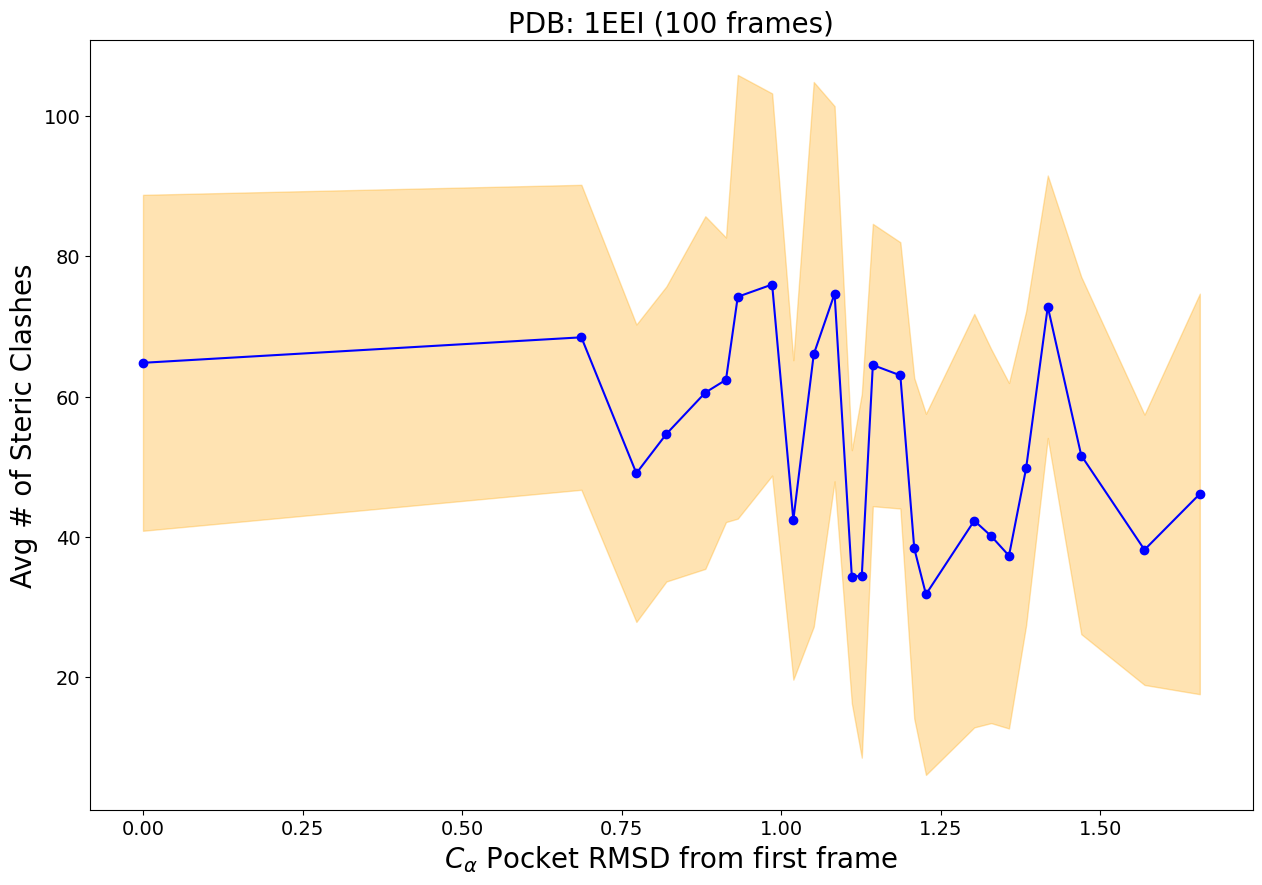

In [150]:
sorted_steric_final_data = sorted(final_steric_data, key=lambda x : x[1]) # sort by RMSD
sorted_rmsds = [rec[1] for rec in sorted_steric_final_data]
sorted_avg_steric = [rec[2] for rec in sorted_steric_final_data]
sorted_std_steric = [rec[3] for rec in sorted_steric_final_data]

itvl = 4
fig = plt.figure(figsize=(15, 10))
plt.plot(sorted_rmsds[::itvl], sorted_avg_steric[::itvl], marker="o", color="blue") # plot rmsd vs avg num steric clashes
plt.fill_between(
    sorted_rmsds[::itvl], 
    np.array(sorted_avg_steric[::itvl]) + np.array(sorted_std_steric[::itvl]), 
    np.array(sorted_avg_steric[::itvl]) - np.array(sorted_std_steric[::itvl]),
    color="orange",
    alpha=0.3
)
plt.xlabel("$C_\\alpha$ Pocket RMSD from first frame", fontsize=20)
plt.ylabel("Avg # of Steric Clashes", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("PDB: 1EEI (100 frames)", fontsize=20)
plt.show()